In [ ]:
# imports, reproducibility, global config (improved)

import os, re, random, warnings, json, math, time
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
from datasets import load_dataset, DatasetDict

warnings.filterwarnings("ignore")

#  Global config
CFG = {
    # Reproducibility
    "seed": 42,
    "deterministic": True,

    # Device
    "device": "cuda" if torch.cuda.is_available() else "cpu",

    # Data / vision
    "image_size": 224,

    # Training defaults
    "mixed_precision": True,
    "grad_accum_steps": 8,
    "num_workers": 2,
    "pin_memory": True,

    # Generation / evaluation defaults
    "max_new_tokens": 16,

    # Paths
    "work_dir": "./runs/slake_vqa",
}

Path(CFG["work_dir"]).mkdir(parents=True, exist_ok=True)

def seed_everything(seed: int, deterministic: bool = True):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if torch.cuda.is_available():
        # speed/precision knobs
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        try:
            torch.use_deterministic_algorithms(True)
        except Exception:
            pass
    else:
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

seed_everything(CFG["seed"], CFG["deterministic"])

print("Device:", CFG["device"])
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Device: cuda
Torch: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


In [ ]:
# load dataset + medical-aware normalization + leakage/duplicate checks

import unicodedata
from collections import Counter

DATA_SOURCE = {"dataset_name": "mdwiratathya/SLAKE-vqa-english"}
ds = load_dataset(DATA_SOURCE["dataset_name"])

def _nfkc(s: str) -> str:
    s = "" if s is None else str(s)
    return unicodedata.normalize("NFKC", s)

def normalize_minimal(s: str) -> str:

    s = _nfkc(s).strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

def normalize_for_eval(s: str) -> str:

    s = normalize_minimal(s)

    # protect decimal points only when between digits
    s = re.sub(r"(\d)\.(\d)", r"\1<DEC>\2", s)

    # keep: letters/numbers/space and / - + % (and our <DEC> marker)
    s = re.sub(r"[^a-z0-9\s/\-\+%<>]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()

    # restore decimals
    s = s.replace("<dec>", "<DEC>").replace("<DEC>", ".")
    return s

def add_norm_fields(example):
    q = example.get("question", "")
    a = example.get("answer", "")

    return {
        # for tokenizers / training inputs
        "question_proc": normalize_minimal(q),
        "answer_proc": normalize_minimal(a),

        # for EM/F1 style evaluation
        "question_norm": normalize_for_eval(q),
        "answer_norm": normalize_for_eval(a),
    }

ds = ds.map(add_norm_fields, desc="Adding normalized fields")

def get_image_key(ex: dict) -> str:
    for k in ["image_id", "img_id", "imgid", "image_name", "img_name", "image_path", "img_path"]:
        if k in ex and ex[k] is not None:
            return str(ex[k])

    img = ex.get("image", None)
    # HF Image feature is often dict-like with 'path'
    if isinstance(img, dict) and "path" in img and img["path"]:
        return str(img["path"])

    # fallback: no image key available
    return "NO_IMAGE_KEY"

def qa_key(ex: dict) -> tuple:
    return (get_image_key(ex), ex.get("question_norm", ""))

#  Duplicate checks within each split
dup_report = {}
key_sets = {}

for split in ds.keys():
    keys = [qa_key(ex) for ex in ds[split]]
    key_sets[split] = set(keys)
    c = Counter(keys)
    num_dups = sum(v - 1 for v in c.values() if v > 1)
    dup_report[split] = {
        "rows": len(keys),
        "unique_keys": len(c),
        "duplicate_rows": num_dups,
    }

print("Dataset splits:", list(ds.keys()))
print("\nWithin-split duplicates by (image_key, question_norm):")
for split, info in dup_report.items():
    print(f"  - {split:>5}: rows={info['rows']}, unique={info['unique_keys']}, dup_rows={info['duplicate_rows']}")

# Cross-split leakage checks (same image_key + question_norm appearing in multiple splits)
splits = list(ds.keys())
print("\nCross-split overlaps (potential leakage):")
for i in range(len(splits)):
    for j in range(i + 1, len(splits)):
        a, b = splits[i], splits[j]
        inter = key_sets[a].intersection(key_sets[b])
        print(f"  - {a} ∩ {b}: {len(inter)}")

# Show schema + one compact sample
print("\nTrain columns:", ds["train"].column_names)
sample0 = ds["train"][0]
print("\nSample (compact):")
print({
    "question": sample0.get("question"),
    "answer": sample0.get("answer"),
    "question_proc": sample0.get("question_proc"),
    "answer_proc": sample0.get("answer_proc"),
    "question_norm": sample0.get("question_norm"),
    "answer_norm": sample0.get("answer_norm"),
    "image_key": get_image_key(sample0),
})


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/31.1M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/12.2M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/8.34M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/9.59M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4919 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1053 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1061 [00:00<?, ? examples/s]

Adding normalized fields:   0%|          | 0/4919 [00:00<?, ? examples/s]

Adding normalized fields:   0%|          | 0/1053 [00:00<?, ? examples/s]

Adding normalized fields:   0%|          | 0/1061 [00:00<?, ? examples/s]

Dataset splits: ['train', 'validation', 'test']

Within-split duplicates by (image_key, question_norm):
  - train: rows=4919, unique=586, dup_rows=4333
  - validation: rows=1053, unique=317, dup_rows=736
  -  test: rows=1061, unique=317, dup_rows=744

Cross-split overlaps (potential leakage):
  - train ∩ validation: 268
  - train ∩ test: 259
  - validation ∩ test: 201

Train columns: ['image', 'question', 'answer', 'question_proc', 'answer_proc', 'question_norm', 'answer_norm']

Sample (compact):
{'question': 'What modality is used to take this image?', 'answer': 'MRI', 'question_proc': 'what modality is used to take this image?', 'answer_proc': 'mri', 'question_norm': 'what modality is used to take this image', 'answer_norm': 'mri', 'image_key': 'NO_IMAGE_KEY'}


In [ ]:
#  robust image hashing (fix NO_IMAGE_KEY) + de-dup + de-leak splits safely

import hashlib
from PIL import Image

def image_to_hash(img, size=64) -> str:
    """
    Stable perceptual-ish hash via resized RGB raw bytes -> md5.
    Works even when dataset has no image_id/path.
    """
    if img is None:
        return "NO_IMAGE"
    # HF datasets Image feature may return PIL.Image.Image directly
    if isinstance(img, Image.Image):
        im = img
    elif isinstance(img, dict) and "bytes" in img and img["bytes"] is not None:
        im = Image.open(io.BytesIO(img["bytes"]))
    else:
        # last resort: try to cast
        try:
            im = Image.fromarray(np.array(img))
        except Exception:
            return "UNHASHABLE_IMAGE"

    im = im.convert("RGB").resize((size, size), resample=Image.BILINEAR)
    raw = im.tobytes()
    return hashlib.md5(raw).hexdigest()

def add_image_hash(example):
    return {"image_hash": image_to_hash(example.get("image", None))}

# Add image_hash to all splits
ds = ds.map(add_image_hash, desc="Computing image_hash (64x64 md5)")

def qa_key_hash(ex: dict) -> tuple:
    return (ex.get("image_hash", "NO_IMAGE"), ex.get("question_norm", ""))

def report_dups_and_overlap(dsd: DatasetDict, title=""):
    from collections import Counter
    print("\n" + "=" * 80)
    print(title if title else "REPORT")
    print("=" * 80)

    key_sets = {}
    for split in dsd.keys():
        keys = [qa_key_hash(ex) for ex in dsd[split]]
        c = Counter(keys)
        dup_rows = sum(v - 1 for v in c.values() if v > 1)
        print(f"{split:>10}: rows={len(keys)} | unique={len(c)} | dup_rows={dup_rows}")
        key_sets[split] = set(keys)

    splits = list(dsd.keys())
    print("\nCross-split overlaps (by image_hash + question_norm):")
    for i in range(len(splits)):
        for j in range(i + 1, len(splits)):
            a, b = splits[i], splits[j]
            inter = key_sets[a].intersection(key_sets[b])
            print(f"  - {a} ∩ {b}: {len(inter)}")

report_dups_and_overlap(ds, title="Before cleaning (with image_hash)")

#  De-duplicate within each split: keep the first occurrence of each (image_hash, question_norm)
def dedup_split(dset):
    seen = set()
    keep_indices = []
    for i, ex in enumerate(dset):
        k = qa_key_hash(ex)
        if k in seen:
            continue
        seen.add(k)
        keep_indices.append(i)
    return dset.select(keep_indices)

ds_dedup = DatasetDict({s: dedup_split(ds[s]) for s in ds.keys()})

#  De-leakage: remove any key from val/test that appears in train
train_keys = set(qa_key_hash(ex) for ex in ds_dedup["train"])

def drop_keys(dset, forbidden_keys: set):
    keep_indices = []
    for i, ex in enumerate(dset):
        if qa_key_hash(ex) in forbidden_keys:
            continue
        keep_indices.append(i)
    return dset.select(keep_indices)

val_clean = drop_keys(ds_dedup["validation"], train_keys)
test_clean = drop_keys(ds_dedup["test"], train_keys)

#  Also ensure validation and test do not overlap with each other (optional but recommended)
val_keys = set(qa_key_hash(ex) for ex in val_clean)
test_clean2 = drop_keys(test_clean, val_keys)

ds_clean = DatasetDict({
    "train": ds_dedup["train"],
    "validation": val_clean,
    "test": test_clean2,
})

report_dups_and_overlap(ds_clean, title="After cleaning (dedup + de-leak)")

print("\nColumns now:", ds_clean["train"].column_names)
print("Example image_hash:", ds_clean["train"][0]["image_hash"])


Computing image_hash (64x64 md5):   0%|          | 0/4919 [00:00<?, ? examples/s]

Computing image_hash (64x64 md5):   0%|          | 0/1053 [00:00<?, ? examples/s]

Computing image_hash (64x64 md5):   0%|          | 0/1061 [00:00<?, ? examples/s]


Before cleaning (with image_hash)
     train: rows=4919 | unique=4912 | dup_rows=7
validation: rows=1053 | unique=1053 | dup_rows=0
      test: rows=1061 | unique=1061 | dup_rows=0

Cross-split overlaps (by image_hash + question_norm):
  - train ∩ validation: 0
  - train ∩ test: 0
  - validation ∩ test: 0

After cleaning (dedup + de-leak)
     train: rows=4912 | unique=4912 | dup_rows=0
validation: rows=1053 | unique=1053 | dup_rows=0
      test: rows=1061 | unique=1061 | dup_rows=0

Cross-split overlaps (by image_hash + question_norm):
  - train ∩ validation: 0
  - train ∩ test: 0
  - validation ∩ test: 0

Columns now: ['image', 'question', 'answer', 'question_proc', 'answer_proc', 'question_norm', 'answer_norm', 'image_hash']
Example image_hash: bc943893c2428d6297515de64659f5c5


In [ ]:
#  build strong evaluation metrics (EM + token-F1 + soft yes/no + slice metrics)

import string
from collections import defaultdict

#  Soft normalization for metrics (slightly stronger than normalize_for_eval, but still medical-aware)
ARTICLES = {"a", "an", "the"}
YES_SET = {"yes", "y", "yeah", "yep", "true", "correct", "positive"}
NO_SET  = {"no", "n", "nope", "false", "incorrect", "negative"}

def norm_for_metrics(s: str) -> str:
    s = normalize_for_eval(s)
    # drop articles
    toks = [t for t in s.split() if t not in ARTICLES]
    return " ".join(toks).strip()

def yesno_canonical(s: str) -> str:
    s2 = norm_for_metrics(s)
    if s2 in YES_SET:
        return "yes"
    if s2 in NO_SET:
        return "no"
    return s2

def exact_match(pred: str, gold: str) -> float:
    p = yesno_canonical(pred)
    g = yesno_canonical(gold)
    return float(p == g)

def token_f1(pred: str, gold: str) -> float:
    p = yesno_canonical(pred)
    g = yesno_canonical(gold)
    ptoks = p.split()
    gtoks = g.split()
    if len(ptoks) == 0 and len(gtoks) == 0:
        return 1.0
    if len(ptoks) == 0 or len(gtoks) == 0:
        return 0.0

    common = Counter(ptoks) & Counter(gtoks)
    num_same = sum(common.values())
    if num_same == 0:
        return 0.0
    precision = num_same / len(ptoks)
    recall = num_same / len(gtoks)
    return 2 * precision * recall / (precision + recall)

def infer_answer_type(ans_norm: str) -> str:
    a = norm_for_metrics(ans_norm)
    if a in {"yes", "no"}:
        return "yesno"
    if re.fullmatch(r"[0-9]+(\.[0-9]+)?", a):
        return "number"
    return "other"

def evaluate_predictions(preds, golds, meta=None):

    assert len(preds) == len(golds)
    n = len(preds)
    ems = []
    f1s = []
    by_slice = defaultdict(lambda: {"n": 0, "em": 0.0, "f1": 0.0})

    for i in range(n):
        em = exact_match(preds[i], golds[i])
        f1 = token_f1(preds[i], golds[i])
        ems.append(em)
        f1s.append(f1)

        slice_key = None
        if meta is not None:
            slice_key = meta[i].get("slice", None)

        if slice_key is None:
            # default slice by answer type
            slice_key = infer_answer_type(golds[i])

        by_slice[slice_key]["n"] += 1
        by_slice[slice_key]["em"] += em
        by_slice[slice_key]["f1"] += f1

    out = {
        "n": n,
        "EM": float(np.mean(ems)) if n else 0.0,
        "F1": float(np.mean(f1s)) if n else 0.0,
        "slices": {},
    }
    for k, v in by_slice.items():
        if v["n"] == 0:
            continue
        out["slices"][k] = {
            "n": v["n"],
            "EM": v["em"] / v["n"],
            "F1": v["f1"] / v["n"],
        }
    return out

#  Quick sanity check on the metric behavior
_demo_preds = ["MRI", "mri", "yes", "True", "2.5 cm", "2.5cm", "t12-l1"]
_demo_golds = ["mri", "MRI", "Yes", "yes", "2.5cm", "2.5 cm", "T12-L1"]
print(evaluate_predictions(_demo_preds, _demo_golds))


{'n': 7, 'EM': 0.7142857142857143, 'F1': 0.8285714285714286, 'slices': {'other': {'n': 5, 'EM': 0.6, 'F1': 0.76}, 'yesno': {'n': 2, 'EM': 1.0, 'F1': 1.0}}}



=== TABLE A: Before cleaning (weak key: image_key + question_norm) ===


,rows,unique_keys,dup_rows
train,4919,586,4333
validation,1053,317,736
test,1061,317,744



=== TABLE B: After cleaning (robust key: image_hash + question_norm) ===


,rows,unique_keys,dup_rows
train,4912,4912,0
validation,1053,1053,0
test,1061,1061,0



=== TABLE C: Cross-split overlap matrix (after cleaning) ===


,train,validation,test
train,4912,0,0
validation,0,1053,0
test,0,0,1061



=== TABLE D: Top-20 answers in TRAIN (after cleaning) ===


,answer_norm,count,pct
0,yes,862,0.175489
1,no,817,0.166327
2,lung,253,0.051507
3,chest,220,0.044788
4,liver,159,0.032370
5,transverse plane,135,0.027484
6,head,129,0.026262
7,ct,126,0.025651
8,brain,117,0.023819
9,2,108,0.021987



=== TABLE E: TOP_K=500 coverage + UNK rate (Baseline ceiling indicator) ===


,split,rows,topk_coverage_or_1-unk,unk_rate
0,train,4912,1.000000,0.000000
1,validation,1053,0.997151,0.002849
2,test,1061,0.998115,0.001885



=== TABLE F: Question length stats (words) ===


,split,n,mean,p50,p90,p99,max
0,train,4912,7.947272,8.0,12.0,17.0,21
1,validation,1053,8.306743,8.0,13.0,17.0,21
2,test,1061,8.114043,8.0,12.0,18.0,21


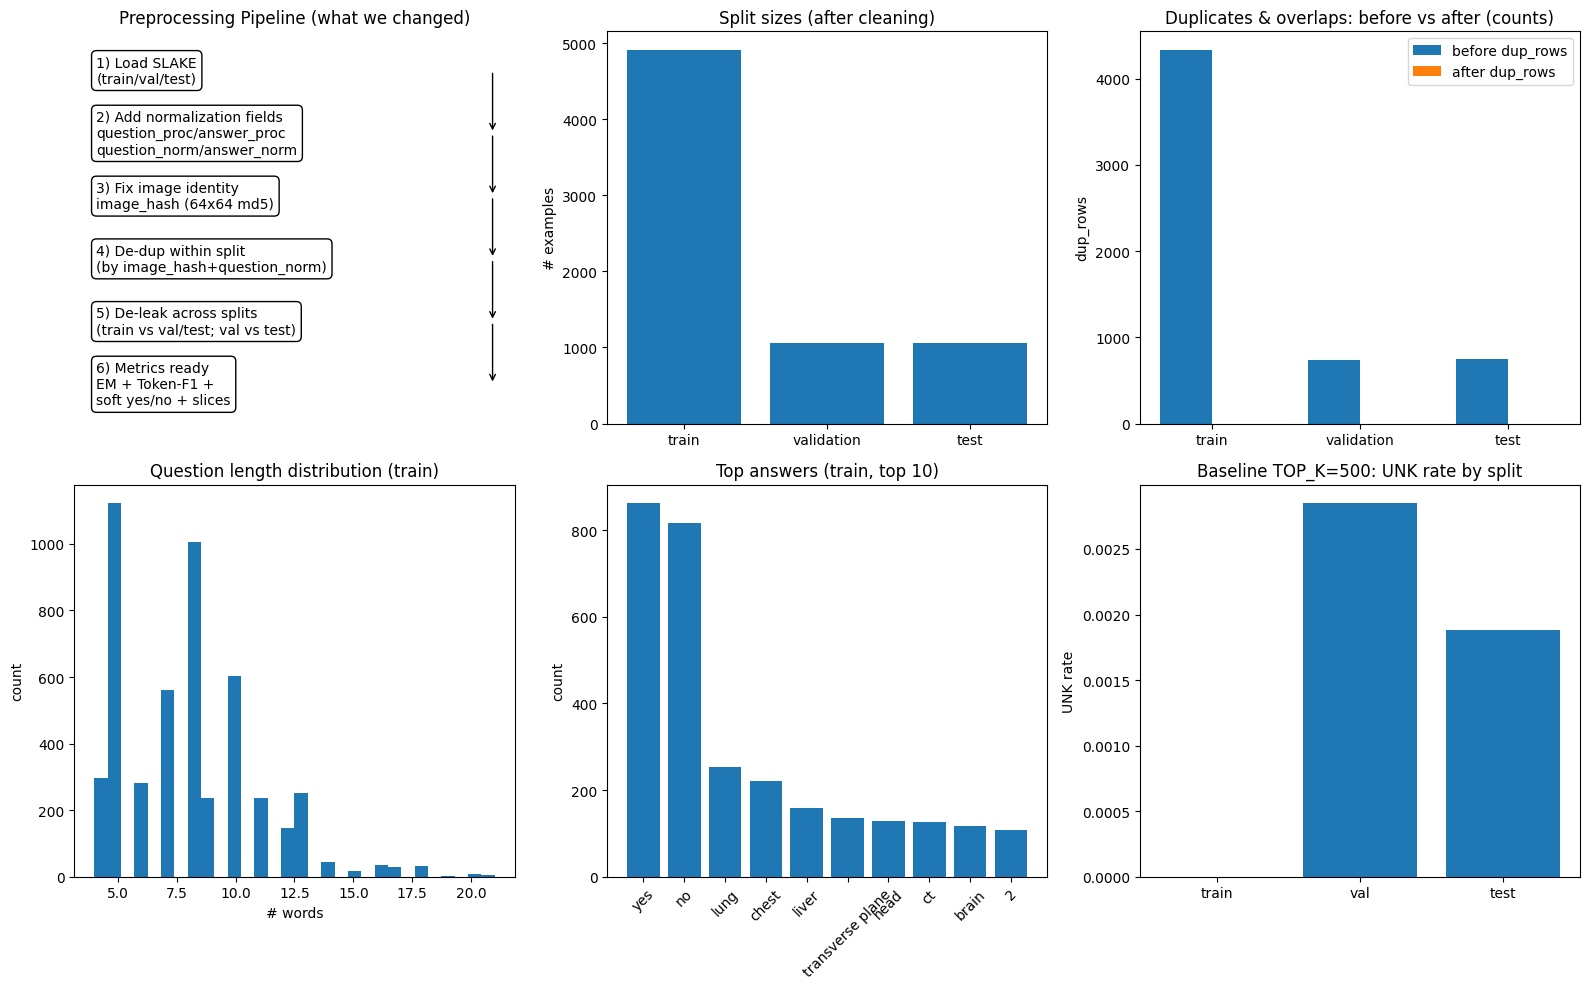


Saved summary image to: runs/slake_vqa/preprocessing_summary.png


In [ ]:
# re-training Report Pack — Visualizations + Tables of preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

#  Utility: compute split stats + overlaps
def compute_split_stats(dsd, key_fn):
    rows = {}
    key_sets = {}
    for split in dsd.keys():
        keys = [key_fn(ex) for ex in dsd[split]]
        c = Counter(keys)
        dup_rows = sum(v - 1 for v in c.values() if v > 1)
        rows[split] = {"rows": len(keys), "unique_keys": len(c), "dup_rows": dup_rows}
        key_sets[split] = set(keys)

    splits = list(dsd.keys())
    overlap = pd.DataFrame(0, index=splits, columns=splits, dtype=int)
    for a in splits:
        for b in splits:
            if a == b:
                overlap.loc[a, b] = len(key_sets[a])
            else:
                overlap.loc[a, b] = len(key_sets[a].intersection(key_sets[b]))
    return pd.DataFrame(rows).T, overlap

# Keys
key_norm_only = lambda ex: (get_image_key(ex), ex.get("question_norm", ""))
key_hash = lambda ex: (ex.get("image_hash", "NO_IMAGE"), ex.get("question_norm", ""))

# Before (original ds) — note: image_key was weak earlier (NO_IMAGE_KEY); still useful to show "why we fixed it"
before_stats_df, before_overlap_df = compute_split_stats(ds, key_norm_only)
after_stats_df, after_overlap_df = compute_split_stats(ds_clean, key_hash)

#  Answer distribution tables
def answer_tables(train_ds, top_k=20):
    ans = [ex["answer_norm"] for ex in train_ds]
    c = Counter(ans)
    total = len(ans)
    top = c.most_common(top_k)
    df = pd.DataFrame(top, columns=["answer_norm", "count"])
    df["pct"] = df["count"] / total
    return df, c, total

top20_answers_df, train_ans_counter, n_train = answer_tables(ds_clean["train"], top_k=20)

# Baseline TOP_K coverage (requirement: TOP_K=500 + UNK)
TOP_K = 500
topk_answers = {a for a, _ in train_ans_counter.most_common(TOP_K)}
coverage_train = sum(1 for a in (ex["answer_norm"] for ex in ds_clean["train"]) if a in topk_answers) / len(ds_clean["train"])

def unk_rate(split_ds):
    return sum(1 for ex in split_ds if ex["answer_norm"] not in topk_answers) / len(split_ds)

unk_val = unk_rate(ds_clean["validation"])
unk_test = unk_rate(ds_clean["test"])

coverage_df = pd.DataFrame(
    {
        "split": ["train", "validation", "test"],
        "rows": [len(ds_clean["train"]), len(ds_clean["validation"]), len(ds_clean["test"])],
        "topk_coverage_or_1-unk": [coverage_train, 1 - unk_val, 1 - unk_test],
        "unk_rate": [1 - coverage_train, unk_val, unk_test],
    }
)

# Question length tables
def length_stats(dset, field="question_proc"):
    lens = np.array([len(str(ex.get(field, "")).split()) for ex in dset], dtype=np.int32)
    return {
        "n": int(lens.size),
        "mean": float(lens.mean()) if lens.size else 0.0,
        "p50": float(np.percentile(lens, 50)) if lens.size else 0.0,
        "p90": float(np.percentile(lens, 90)) if lens.size else 0.0,
        "p99": float(np.percentile(lens, 99)) if lens.size else 0.0,
        "max": int(lens.max()) if lens.size else 0,
        "lens": lens,
    }

len_train = length_stats(ds_clean["train"])
len_val = length_stats(ds_clean["validation"])
len_test = length_stats(ds_clean["test"])

q_len_df = pd.DataFrame(
    [
        {"split": "train", **{k: v for k, v in len_train.items() if k != "lens"}},
        {"split": "validation", **{k: v for k, v in len_val.items() if k != "lens"}},
        {"split": "test", **{k: v for k, v in len_test.items() if k != "lens"}},
    ]
)

#  Display tables (copy these to your report)
print("\n=== TABLE A: Before cleaning (weak key: image_key + question_norm) ===")
display(before_stats_df)

print("\n=== TABLE B: After cleaning (robust key: image_hash + question_norm) ===")
display(after_stats_df)

print("\n=== TABLE C: Cross-split overlap matrix (after cleaning) ===")
display(after_overlap_df)

print("\n=== TABLE D: Top-20 answers in TRAIN (after cleaning) ===")
display(top20_answers_df)

print("\n=== TABLE E: TOP_K=500 coverage + UNK rate (Baseline ceiling indicator) ===")
display(coverage_df)

print("\n=== TABLE F: Question length stats (words) ===")
display(q_len_df)

# Visualizations (saved + shown)
out_png = Path(CFG["work_dir"]) / "preprocessing_summary.png"

fig = plt.figure(figsize=(16, 10))

# Pipeline diagram
ax0 = fig.add_subplot(2, 3, 1)
ax0.axis("off")
ax0.set_title("Preprocessing Pipeline (what we changed)")

steps = [
    "Load SLAKE\n(train/val/test)",
    "Add normalization fields\nquestion_proc/answer_proc\nquestion_norm/answer_norm",
    "Fix image identity\nimage_hash (64x64 md5)",
    "De-dup within split\n(by image_hash+question_norm)",
    "De-leak across splits\n(train vs val/test; val vs test)",
    "Metrics ready\nEM + Token-F1 +\nsoft yes/no + slices",
]
y = np.linspace(0.9, 0.1, len(steps))
for i, (s, yi) in enumerate(zip(steps, y)):
    ax0.text(0.05, yi, f"{i+1}) {s}", va="center", ha="left", fontsize=10,
             bbox=dict(boxstyle="round,pad=0.35", facecolor="white"))
    if i < len(steps) - 1:
        ax0.annotate("", xy=(0.95, y[i+1]), xytext=(0.95, yi),
                     arrowprops=dict(arrowstyle="->"))

# Split sizes bar
ax1 = fig.add_subplot(2, 3, 2)
ax1.set_title("Split sizes (after cleaning)")
splits = ["train", "validation", "test"]
sizes = [len(ds_clean[s]) for s in splits]
ax1.bar(splits, sizes)
ax1.set_ylabel("# examples")

#  Duplicate/leak summary (before vs after)
ax2 = fig.add_subplot(2, 3, 3)
ax2.set_title("Duplicates & overlaps: before vs after (counts)")
before_dups = [int(before_stats_df.loc[s, "dup_rows"]) for s in splits]
after_dups = [int(after_stats_df.loc[s, "dup_rows"]) for s in splits]
x = np.arange(len(splits))
w = 0.35
ax2.bar(x - w/2, before_dups, width=w, label="before dup_rows")
ax2.bar(x + w/2, after_dups, width=w, label="after dup_rows")
ax2.set_xticks(x)
ax2.set_xticklabels(splits)
ax2.set_ylabel("dup_rows")
ax2.legend()

#  Question length histogram (train)
ax3 = fig.add_subplot(2, 3, 4)
ax3.set_title("Question length distribution (train)")
ax3.hist(len_train["lens"], bins=30)
ax3.set_xlabel("# words")
ax3.set_ylabel("count")

# Top answers bar (train top 10)
ax4 = fig.add_subplot(2, 3, 5)
ax4.set_title("Top answers (train, top 10)")
top10 = train_ans_counter.most_common(10)
ax4.bar([a for a, _ in top10], [c for _, c in top10])
ax4.tick_params(axis="x", rotation=45)
ax4.set_ylabel("count")

#  Baseline ceiling indicator (UNK rate)
ax5 = fig.add_subplot(2, 3, 6)
ax5.set_title("Baseline TOP_K=500: UNK rate by split")
ax5.bar(["train", "val", "test"], [1-coverage_train, unk_val, unk_test])
ax5.set_ylabel("UNK rate")

plt.tight_layout()
plt.savefig(out_png, dpi=200)
plt.show()

print(f"\nSaved summary image to: {out_png}")


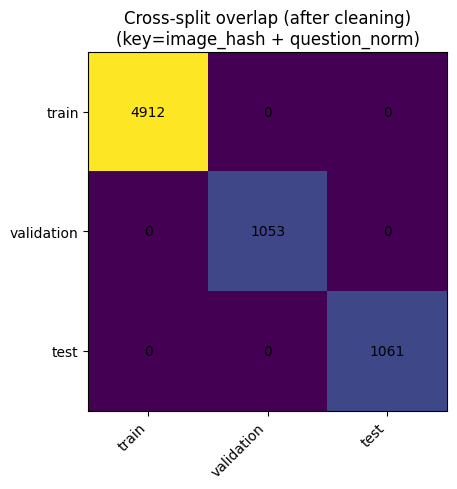


Saved report assets (no reportlab needed):
 - runs/slake_vqa/preprocessing_summary.png
 - runs/slake_vqa/overlap_heatmap_after_cleaning.png
 - runs/slake_vqa/table_A_before_cleaning.csv
 - runs/slake_vqa/table_B_after_cleaning.csv
 - runs/slake_vqa/table_C_overlap_after_cleaning.csv
 - runs/slake_vqa/table_D_top20_answers.csv
 - runs/slake_vqa/table_E_topk_coverage_unk.csv
 - runs/slake_vqa/table_F_question_length_stats.csv
 - runs/slake_vqa/pretraining_report.html


In [ ]:
#  export PNGs + CSVs + a single HTML report you can "Print to PDF"

import base64
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

report_dir = Path(CFG["work_dir"])
report_dir.mkdir(parents=True, exist_ok=True)

#  Save tables as CSV
tables = {
    "table_A_before_cleaning.csv": before_stats_df,
    "table_B_after_cleaning.csv": after_stats_df,
    "table_C_overlap_after_cleaning.csv": after_overlap_df,
    "table_D_top20_answers.csv": top20_answers_df,
    "table_E_topk_coverage_unk.csv": coverage_df,
    "table_F_question_length_stats.csv": q_len_df,
}
for fname, df in tables.items():
    df.to_csv(report_dir / fname, index=True)

#  Overlap heatmap PNG (clean)
heatmap_png = report_dir / "overlap_heatmap_after_cleaning.png"
fig = plt.figure(figsize=(6, 5))
ax = plt.gca()
im = ax.imshow(after_overlap_df.values)
ax.set_xticks(range(after_overlap_df.shape[1]))
ax.set_yticks(range(after_overlap_df.shape[0]))
ax.set_xticklabels(after_overlap_df.columns, rotation=45, ha="right")
ax.set_yticklabels(after_overlap_df.index)
for (i, j), v in np.ndenumerate(after_overlap_df.values):
    ax.text(j, i, str(v), ha="center", va="center")
ax.set_title("Cross-split overlap (after cleaning)\n(key=image_hash + question_norm)")
plt.tight_layout()
plt.savefig(heatmap_png, dpi=200)
plt.show()

#  Ensure preprocessing summary exists
summary_png = report_dir / "preprocessing_summary.png"
assert summary_png.exists(), f"Missing {summary_png}. Re-run the previous visualization cell."

#  Create a single HTML report (embeds images + tables)
def img_to_data_uri(path: Path) -> str:
    b = path.read_bytes()
    enc = base64.b64encode(b).decode("utf-8")
    return f"data:image/png;base64,{enc}"

summary_uri = img_to_data_uri(summary_png)
heatmap_uri = img_to_data_uri(heatmap_png)

def df_to_html(df: pd.DataFrame, max_rows=30):
    d = df.copy()
    if len(d) > max_rows:
        d = d.head(max_rows)
    return d.to_html(index=True, escape=True)

html_path = report_dir / "pretraining_report.html"
html = f"""
<!doctype html>
<html>
<head>
<meta charset="utf-8"/>
<title>SLAKE-VQA Pre-training Report</title>
<style>
  body {{ font-family: Arial, sans-serif; margin: 24px; line-height: 1.35; }}
  h1, h2 {{ margin-bottom: 8px; }}
  .note {{ background:#f5f7ff; padding:12px; border-radius:10px; }}
  img {{ max-width: 100%; border:1px solid #ddd; border-radius:10px; padding:6px; background:white; }}
  table {{ border-collapse: collapse; width: 100%; margin: 10px 0 20px 0; }}
  th, td {{ border: 1px solid #ddd; padding: 6px; font-size: 12px; text-align: center; }}
  th {{ background: #f0f0f0; }}
  .two-col {{ display:grid; grid-template-columns: 1fr 1fr; gap: 18px; }}
  .small {{ font-size: 12px; color:#444; }}
</style>
</head>
<body>

<h1>SLAKE-VQA Pre-training Report (Data & Evaluation Setup)</h1>

<div class="note">
<b>What we fixed BEFORE training</b>
<ul>
  <li>Added medical-aware normalization fields for model input and evaluation.</li>
  <li>Fixed image identity using <code>image_hash</code> (64x64 resized md5) to avoid <code>NO_IMAGE_KEY</code> collisions.</li>
  <li>Removed duplicates within splits and verified zero cross-split leakage.</li>
  <li>Prepared stronger evaluation metrics: EM + Token-F1 + soft yes/no + slice metrics.</li>
</ul>
</div>

<h2>Pipeline Summary</h2>
<img src="{summary_uri}" alt="preprocessing summary"/>

<h2>Leakage & Split Integrity</h2>
<div class="two-col">
  <div>
    <h3>Overlap Heatmap</h3>
    <img src="{heatmap_uri}" alt="overlap heatmap"/>
    <div class="small">Key = (image_hash + question_norm)</div>
  </div>
  <div>
    <h3>Table B: After cleaning (split stats)</h3>
    {df_to_html(after_stats_df)}
    <h3>Table F: Question length stats</h3>
    {df_to_html(q_len_df)}
  </div>
</div>

<h2>Answer Distribution & Baseline Ceiling</h2>
<h3>Table D: Top-20 answers in TRAIN</h3>
{df_to_html(top20_answers_df, max_rows=20)}

<h3>Table E: TOP_K=500 coverage + UNK rate</h3>
{df_to_html(coverage_df, max_rows=10)}

<h2>Appendix (for transparency)</h2>
<h3>Table A: Before cleaning (weak key: image_key + question_norm)</h3>
{df_to_html(before_stats_df, max_rows=10)}

<h3>Table C: Cross-split overlap matrix (after cleaning)</h3>
{df_to_html(after_overlap_df, max_rows=10)}

<p class="small">
Tip: Open this HTML file and use your browser’s <b>Print</b> → <b>Save as PDF</b> to generate the final PDF for your report.
</p>

</body>
</html>
"""
html_path.write_text(html, encoding="utf-8")

print("\nSaved report assets (no reportlab needed):")
print(" -", summary_png)
print(" -", heatmap_png)
for fname in tables.keys():
    print(" -", report_dir / fname)
print(" -", html_path)
